### 绘制时频图

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

def plot_stereo_spectrogram(
    wav_path: str,
    nfft: int = 1024,
    hop: int = 256,
    window: str = "hann",
    dynamic_range_db: float = 80.0,
    fmax=None
):
    """
    绘制立体声 WAV 的两个通道时频图（使用 jet 色图）。

    参数:
        wav_path           : str, WAV 文件路径
        nfft               : int, STFT 窗长(window length)
        hop                : int, 帧移(hop length), noverlap = nfft - hop
        window             : str, 窗函数名称（scipy.signal 支持的窗，如 'hann'）
        dynamic_range_db   : float, 色标动态范围Δ（vmin = vmax - Δ）
        fmax               : float|None, 频率上限(Hz)，None 则为 Nyquist

    行为:
        - 若是单通道，则复制为两通道显示（便于统一接口）。
        - 若通道数 > 2，仅取前两个通道。
    """
    # 读取音频
    sr, data = wavfile.read(wav_path)  # data: (N,) or (N, C)
    if data.ndim == 1:
        # 单通道 -> 复制成两通道
        data = np.stack([data, data], axis=-1)
    elif data.ndim == 2 and data.shape[1] >= 2:
        data = data[:, :2]  # 仅保留前两个通道
    else:
        raise ValueError(f"Unsupported audio shape: {data.shape}")

    # 归一化到 [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        maxv = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / maxv
    else:
        data = data.astype(np.float32)

    # STFT -> dB
    def stft_db(x: np.ndarray):
        f, t, Z = signal.stft(
            x, fs=sr, window=window,
            nperseg=nfft, noverlap=nfft - hop,
            boundary=None, padded=False
        )
        S_db = 20.0 * np.log10(np.abs(Z) + 1e-12)
        return f, t, S_db

    f0, t0, S0 = stft_db(data[:, 0])
    f1, t1, S1 = stft_db(data[:, 1])

    # 频率上限
    nyq = sr / 2.0
    if (fmax is None) or (fmax > nyq):
        fmax = nyq

    idx0 = f0 <= fmax
    idx1 = f1 <= fmax
    f0, S0 = f0[idx0], S0[idx0, :]
    f1, S1 = f1[idx1], S1[idx1, :]

    # 统一色标
    vmax = float(max(np.max(S0), np.max(S1)))
    vmin = vmax - float(dynamic_range_db)

    # 作图
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)

    im0 = axes[0].pcolormesh(t0, f0, S0, shading="gouraud", cmap="jet", vmin=vmin, vmax=vmax)
    axes[0].set_title("Channel 0 Spectrogram")
    axes[0].set_ylabel("Frequency (Hz)")
    axes[0].set_ylim(0, fmax)

    im1 = axes[1].pcolormesh(t1, f1, S1, shading="gouraud", cmap="jet", vmin=vmin, vmax=vmax)
    axes[1].set_title("Channel 1 Spectrogram")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Frequency (Hz)")
    axes[1].set_ylim(0, fmax)

    # 单一 colorbar（对应相同的 dB 量纲）
    cbar = fig.colorbar(im1, ax=axes, orientation="vertical", fraction=0.03, pad=0.03)
    cbar.set_label("Magnitude (dB)")

    plt.show()

# 示例:
# 


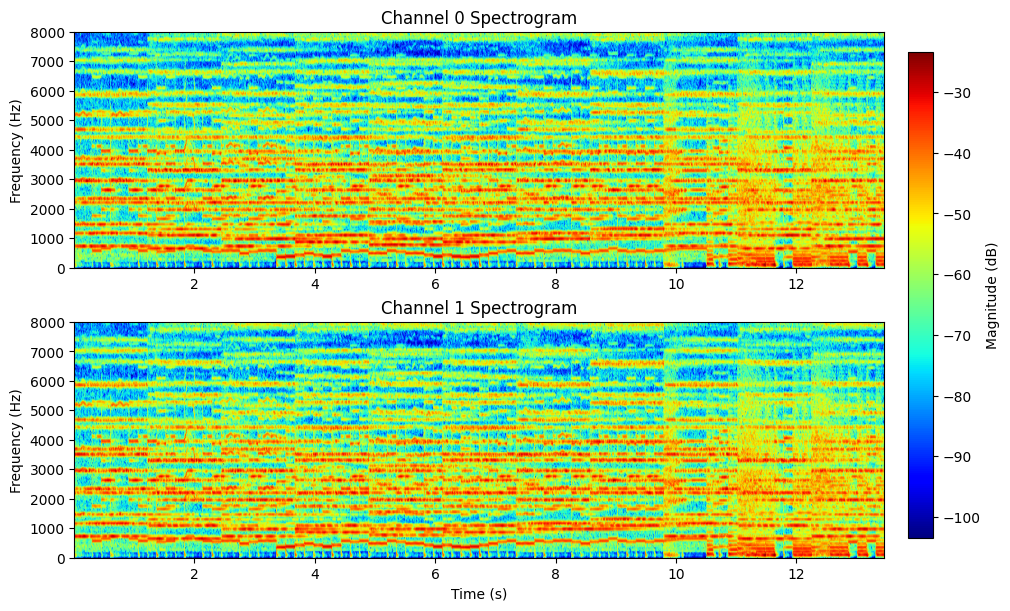

In [5]:
plot_stereo_spectrogram("canonrock.wav", nfft=1024, hop=256, dynamic_range_db=80, fmax=8000)

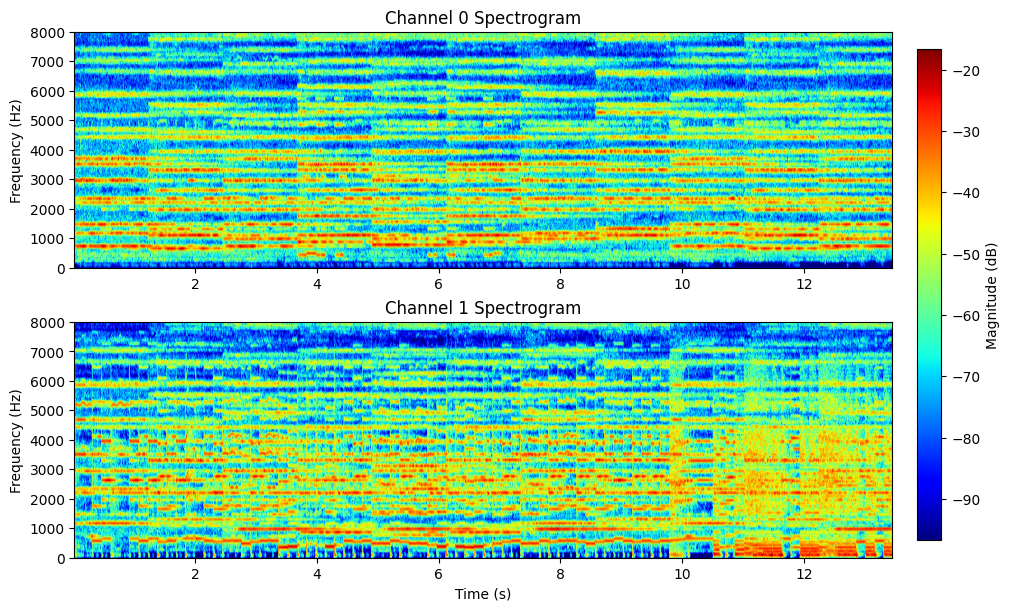

In [6]:
plot_stereo_spectrogram("R:/code/SoundSourceSeparation/FastMNMF2_IP-sep-M=2-S=2-F=513-K=64-init=twostep_50it-g=0.5-bit=64-intv_norm=10-ID=canonrock.wav", nfft=1024, hop=256, dynamic_range_db=80, fmax=8000)

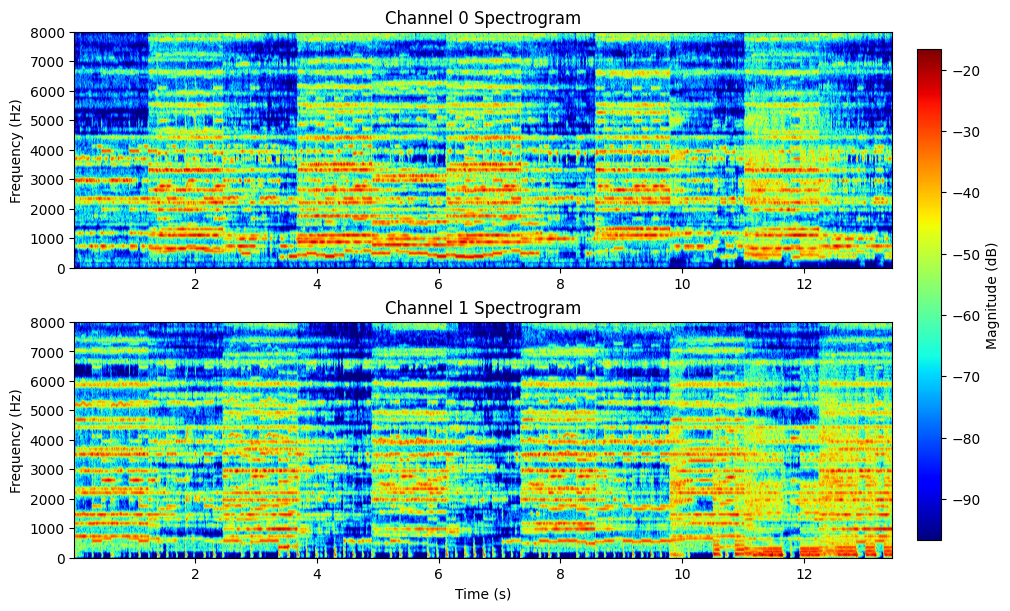

In [9]:
plot_stereo_spectrogram("R:/code/SoundSourceSeparation/FastMNMF2_IP-sep-M=2-S=2-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=canonrock.wav", nfft=1024, hop=256, dynamic_range_db=80, fmax=8000)

In [2]:
import numpy as np

# ============ 音频读取（audio loading） ============
def load_wav_multichannel(path):
    """
    加载多通道 WAV（wave），返回 float32 的 (num_samples, num_channels)。
    优先使用 soundfile；若不可用，则使用 wave+numpy。
    """
    try:
        import soundfile as sf
        data, sr = sf.read(path, always_2d=True)  # shape: [T, C]
        data = data.astype(np.float32, copy=False)
        return data, sr
    except Exception:
        import wave, struct
        with wave.open(path, 'rb') as wf:
            n_channels = wf.getnchannels()
            sr = wf.getframerate()
            n_frames = wf.getnframes()
            sampwidth = wf.getsampwidth()
            raw = wf.readframes(n_frames)
        # 仅处理 16-bit PCM（常见）；其他位宽可按需扩展
        if sampwidth != 2:
            raise RuntimeError("仅内置支持16-bit PCM；请安装 soundfile 以支持更多格式。")
        # 解包为 int16，重塑为 [T, C]
        data_i16 = np.frombuffer(raw, dtype=np.int16)
        data_i16 = data_i16.reshape(-1, n_channels)
        # 归一化到 [-1,1]
        data = (data_i16 / 32768.0).astype(np.float32)
        return data, sr

# ============ 时域 SCM（time-domain SCM） ============
def scm_time_domain(x_tc, eps=0.0):
    """
    计算时域样本协方差（SCM）。
    输入 x_tc: [T, C]，实数或复数；输出 R_cc: [C, C]（Hermitian）。
    """
    # 去均值（demean）更稳定：R = E[(x-mean)(x-mean)^H]
    x = x_tc - np.mean(x_tc, axis=0, keepdims=True)
    R = (x.conj().T @ x) / x.shape[0]
    if eps > 0:
        R = R + eps * np.eye(R.shape[0], dtype=R.dtype)
    return R

# ============ 简单 STFT（short-time Fourier transform） ============
def stft_multichannel(x_tc, n_fft=1024, hop=512, window='hann'):
    """
    朴素 STFT 实现，输入 x_tc:[T, C]，输出 X_fct:[F, C, N] 复数
    F = n_fft//2+1, N = 帧数
    """
    T, C = x_tc.shape
    if window == 'hann':
        win = np.hanning(n_fft).astype(np.float32)
    else:
        raise ValueError("仅内置 hann 窗函数。")

    # 逐帧分帧
    n_frames = 1 + (T - n_fft) // hop if T >= n_fft else 0
    if n_frames <= 0:
        raise RuntimeError("音频太短，无法分帧：请缩小 n_fft 或使用更长音频。")

    F = n_fft // 2 + 1
    X_fct = np.empty((F, C, n_frames), dtype=np.complex128)

    for i in range(n_frames):
        s = i * hop
        frame = x_tc[s:s+n_fft, :] * win[:, None]  # [n_fft, C]
        # FFT 并保留正频
        spec = np.fft.rfft(frame, n=n_fft, axis=0)  # [F, C]
        X_fct[:, :, i] = spec

    return X_fct  # [F, C, N]

# ============ 频域逐频 SCM ============
def scm_per_frequency(X_fct, eps=0.0):
    """
    对每个频点 f 计算 SCM(f)。
    输入 X_fct: [F, C, N]；输出 R_fcc: [F, C, C]
    """
    F, C, N = X_fct.shape
    R_fcc = np.empty((F, C, C), dtype=np.complex128)
    for f in range(F):
        X_cn = X_fct[f, :, :]  # [C, N]
        # 去均值（可选）：默认频域幅相不做去均值；若要稳健可开启
        # X_cn = X_cn - X_cn.mean(axis=1, keepdims=True)
        R = (X_cn @ X_cn.conj().T) / N  # [C, C]
        if eps > 0:
            R = R + eps * np.eye(C, dtype=np.complex128)
        R_fcc[f] = R
    return R_fcc

# ============ 打印与演示 ============
def print_matrix(M, name, max_rows=4, precision=4):
    np.set_printoptions(precision=precision, suppress=True)
    print(f"\n{name} 形状: {M.shape}")
    # 只打印前 max_rows 行，避免过长
    to_show = M if M.shape[0] <= max_rows else M[:max_rows]
    print(to_show)



In [4]:
wav_path = "02_single.wav"  # <-- 替换为你的文件路径

x_tc, sr = load_wav_multichannel(wav_path)
T, C = x_tc.shape
if C != 4:
    raise RuntimeError(f"期望4通道，但文件是 {C} 通道。请提供4通道音频。")
print(f"采样率(sample rate, Hz): {sr}, 时长(s): {T/sr:.2f}, 通道数(channels): {C}")

# ----- 1) 时域 SCM -----
R_time = scm_time_domain(x_tc, eps=0.0)
print_matrix(R_time, "时域SCM（time-domain covariance, R_time）")

# ----- 2) 频域逐频 SCM -----
n_fft, hop = 1024, 512
X_fct = stft_multichannel(x_tc, n_fft=n_fft, hop=hop, window='hann')  # [F,C,N]
R_fcc = scm_per_frequency(X_fct, eps=0.0)  # [F,C,C]
F = R_fcc.shape[0]

# 示例：打印三个代表性频点的 SCM（例如 250Hz、1kHz、4kHz 附近）
freqs = np.fft.rfftfreq(n_fft, d=1.0/sr)  # [F]
targets = [250, 1000, 4000]
for tgt in targets:
    idx = int(np.argmin(np.abs(freqs - tgt)))
    print_matrix(R_fcc[idx], f"频域SCM R(f={freqs[idx]:.1f} Hz)")

# 可选：检查秩（numerical rank）
def numerical_rank(A, tol=1e-8):
    s = np.linalg.svd(A, compute_uv=False)
    return int(np.sum(s > tol * s.max()))

print("\n数值秩（numerical rank）检查：")
print(f"rank(R_time) = {numerical_rank(R_time)}")
for tgt in targets:
    idx = int(np.argmin(np.abs(freqs - tgt)))
    rnk = numerical_rank(R_fcc[idx])
    print(f"rank(R_fcc at ~{freqs[idx]:.1f} Hz) = {rnk}")

采样率(sample rate, Hz): 48000, 时长(s): 10.00, 通道数(channels): 4

时域SCM（time-domain covariance, R_time） 形状: (4, 4)
[[ 0.  0. -0.  0.]
 [ 0.  0. -0. -0.]
 [-0. -0.  0.  0.]
 [ 0. -0.  0.  0.]]

频域SCM R(f=234.4 Hz) 形状: (4, 4)
[[0.0041+0.j     0.0041-0.0003j 0.0043-0.0009j 0.0044-0.0012j]
 [0.0041+0.0003j 0.0043+0.j     0.0046-0.0005j 0.0047-0.0008j]
 [0.0043+0.0009j 0.0046+0.0005j 0.0051+0.j     0.0053-0.0003j]
 [0.0044+0.0012j 0.0047+0.0008j 0.0053+0.0003j 0.0057+0.j    ]]

频域SCM R(f=984.4 Hz) 形状: (4, 4)
[[0.0014+0.j     0.0015-0.0005j 0.0011-0.0013j 0.0007-0.0015j]
 [0.0015+0.0005j 0.0021+0.j     0.0023-0.0013j 0.0017-0.0017j]
 [0.0011+0.0013j 0.0023+0.0013j 0.0037+0.j     0.0035-0.0009j]
 [0.0007+0.0015j 0.0017+0.0017j 0.0035+0.0009j 0.0038+0.j    ]]

频域SCM R(f=3984.4 Hz) 形状: (4, 4)
[[ 0.0054+0.j     -0.0001-0.0031j -0.0049+0.0018j  0.0013+0.0025j]
 [-0.0001+0.0031j  0.0034+0.j     -0.001 -0.0028j -0.0027+0.0005j]
 [-0.0049-0.0018j -0.001 +0.0028j  0.0064+0.j     -0.0002-0.0027j]
 [ 0.0013

In [6]:
def pca_from_cov(R_cc):
    """
    对协方差矩阵（covariance matrix, R_cc）进行 PCA/特征分解：
    返回 U, D(对角), evals(降序), evr(方差解释率), recon_err(重构误差).
    """
    # Hermitian/Symmetric 特征分解
    evals, evecs = np.linalg.eigh(R_cc)
    # 降序排序
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    U = evecs[:, idx]
    D = np.diag(evals)

    # 解释率（explained variance ratio）
    s = evals.sum()
    evr = evals / s if s > 0 else np.zeros_like(evals)

    # 重构误差 ||R - U D U^H||_F
    R_rec = U @ D @ (U.conj().T)
    recon_err = np.linalg.norm(R_cc - R_rec, ord="fro")

    return U, D, evals, evr, recon_err

In [7]:
U_time, D_time, evals_time, evr_time, recon_err_time = pca_from_cov(R_time)

# 打印结果
np.set_printoptions(precision=6, suppress=False)
print("\n[时域SCM PCA] 特征值（eigenvalues, 降序）:")
print(evals_time)
print("\n[时域SCM PCA] 方差解释率（explained variance ratio）:")
print(evr_time)
print(f"\n[时域SCM PCA] 重构误差（Frobenius norm）: {recon_err_time:.3e}")

# 可选：打印 D 与 U（注意：U 可能很长）
print_matrix(D_time, "特征值对角矩阵 D（diagonal eigenvalue matrix）", precision=6, max_rows=10)
print_matrix(U_time, "特征向量矩阵 U（eigenvectors, 列为主成分）", precision=6, max_rows=10)

# 验证对角化（数值应近似对角）
D_check = U_time.conj().T @ R_time @ U_time
print_matrix(D_check, "检验 U^H R U（应近似对角）", precision=6, max_rows=10)


[时域SCM PCA] 特征值（eigenvalues, 降序）:
[2.385622e-06 2.127378e-06 1.503519e-06 1.242380e-06]

[时域SCM PCA] 方差解释率（explained variance ratio）:
[0.328648 0.293072 0.207128 0.171153]

[时域SCM PCA] 重构误差（Frobenius norm）: 1.908e-21

特征值对角矩阵 D（diagonal eigenvalue matrix） 形状: (4, 4)
[[0.000002 0.       0.       0.      ]
 [0.       0.000002 0.       0.      ]
 [0.       0.       0.000002 0.      ]
 [0.       0.       0.       0.000001]]

特征向量矩阵 U（eigenvectors, 列为主成分） 形状: (4, 4)
[[ 0.077111 -0.684958 -0.033643  0.723709]
 [-0.081972 -0.661871 -0.388606 -0.635762]
 [ 0.704826  0.213652 -0.669597  0.095985]
 [ 0.700396 -0.217054  0.632055 -0.250677]]

检验 U^H R U（应近似对角） 形状: (4, 4)
[[ 0.000002  0.        0.       -0.      ]
 [ 0.        0.000002  0.        0.      ]
 [ 0.        0.        0.000002  0.      ]
 [-0.        0.        0.        0.000001]]


In [9]:
import numpy as np
import pandas as pd

# 特征值对角矩阵 D
D = np.array([
    [1.009950e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00],
    [0.000000e+00, 8.198894e-04, 0.000000e+00, 0.000000e+00],
    [0.000000e+00, 0.000000e+00, 1.806434e-04, 0.000000e+00],
    [0.000000e+00, 0.000000e+00, 0.000000e+00, 6.366742e-06]
])

# 特征向量矩阵 U
U = np.array([
    [-0.313091+0.j,       -0.704419-0.j,       -0.520274+0.j,       0.367536+0.j],
    [-0.411751-0.143089j, -0.436795-0.147688j, 0.404441+0.203787j, -0.6154  -0.116475j],
    [-0.392517-0.454789j,  0.140538+0.159333j, 0.429363+0.232408j,  0.54278 +0.24695j ],
    [-0.26028 -0.532272j,  0.218382+0.44538j, -0.345906-0.407672j, -0.292826-0.176897j]
])

SCM = np.array(
    [[0.0014+0.j,     0.0015-0.0005j, 0.0011-0.0013j, 0.0007-0.0015j],
 [0.0015+0.0005j, 0.0021+0.j,     0.0023-0.0013j, 0.0017-0.0017j],
 [0.0011+0.0013j, 0.0023+0.0013j, 0.0037+0.j,     0.0035-0.0009j],
 [0.0007+0.0015j, 0.0017+0.0017j, 0.0035+0.0009j, 0.0038+0.j    ]
])

# 转成 DataFrame（复数转字符串方便Excel显示）
df_D = pd.DataFrame(D)
df_U = pd.DataFrame(U.astype(str))  # 把复数转字符串，Excel才能看懂
df_U_real = pd.DataFrame(U.real)  # 实部
df_SCM = pd.DataFrame(SCM.astype(str))
df_SCM_real = pd.DataFrame(SCM.real)  # 实部

# 写入 Excel，不同 sheet 保存
with pd.ExcelWriter("scm_eigendecomp.xlsx") as writer:
    df_D.to_excel(writer, sheet_name="D_eigenvalues", index=False, header=False)
    df_U.to_excel(writer, sheet_name="U_eigenvectors", index=False, header=False)
    df_U_real.to_excel(writer, sheet_name="U_eigenvectors_real", index=False, header=False)
    df_SCM.to_excel(writer, sheet_name="SCM", index=False, header=False)
    df_SCM_real.to_excel(writer, sheet_name="SCM_real", index=False, header=False)

print("已保存到 scm_eigendecomp.xlsx")

已保存到 scm_eigendecomp.xlsx


In [15]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram_for_each_channel(audio_path):
    """
    加载一个音频文件，并为它的每一个通道绘制一张时频图。

    参数:
    audio_path (str): 音频文件的路径。
    """
    try:
        # 1. 加载音频文件
        # y 是音频时间序列 (audio time series)
        # sr 是采样率 (sampling rate)
        # mono=False 表示加载所有通道
        y, sr = librosa.load(audio_path, mono=False, sr=None)
        
        # 2. 检查音频的维度以确定通道数
        # librosa.load 加载的音频，如果为单通道，shape为(n,)
        # 如果为多通道，shape为(num_channels, n)
        if y.ndim == 1:
            num_channels = 1
            # 为了方便处理，将其转换为 (1, n) 的形式
            y = y.reshape(1, -1)
        else:
            num_channels = y.shape[0]
            
        print(f"音频加载成功: {audio_path}")
        print(f"采样率 (Sampling Rate): {sr} Hz")
        print(f"通道数 (Number of Channels): {num_channels}")
        print(f"音频时长 (Duration): {y.shape[1] / sr:.2f} 秒")

        # 3. 为每一个通道计算并绘制时频图
        for i in range(num_channels):
            # 提取当前通道的数据
            y_channel = y[i, :]
            
            # 计算短时傅里叶变换 (Short-Time Fourier Transform, STFT)
            # D 是一个复数矩阵，包含了幅度和相位信息
            D = librosa.stft(y_channel)
            
            # 将幅度转换为分贝 (decibels) 单位
            # np.abs(D) 取幅度, librosa.amplitude_to_db 将其转换为dB尺度
            DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            
            # 4. 绘制时频图
            fig, ax = plt.subplots(figsize=(10, 4))
            
            # 使用 librosa.display.specshow 来绘制
            # x_axis='time' 表示x轴是时间
            # y_axis='log' 表示y轴是对数频率
            # cmap='jet' 设置颜色图为 jet
            img = librosa.display.specshow(DB, sr=sr, x_axis='time', cmap='jet', ax=ax, vmax=0, vmin=-60,y_axis = 'linear')
            
            # 添加颜色条 (colorbar)
            fig.colorbar(img, ax=ax, format='%+2.0f dB', label='Intensity')
            
            # 设置图表标题
            ax.set_title(f'Spectrogram - Channel{i + 1}')
            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Frequency [Hz]')
            
            # 自动调整布局，防止标签重叠
            plt.tight_layout()
            
            # 显示图表
            plt.show()

    except Exception as e:
        print(f"处理文件时发生错误: {e}")



音频加载成功: R:\code\SoundSourceSeparation\FastMNMF2_IP-sep-M=4-S=3-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=00_02_normal.wav
采样率 (Sampling Rate): 48000 Hz
通道数 (Number of Channels): 3
音频时长 (Duration): 10.00 秒


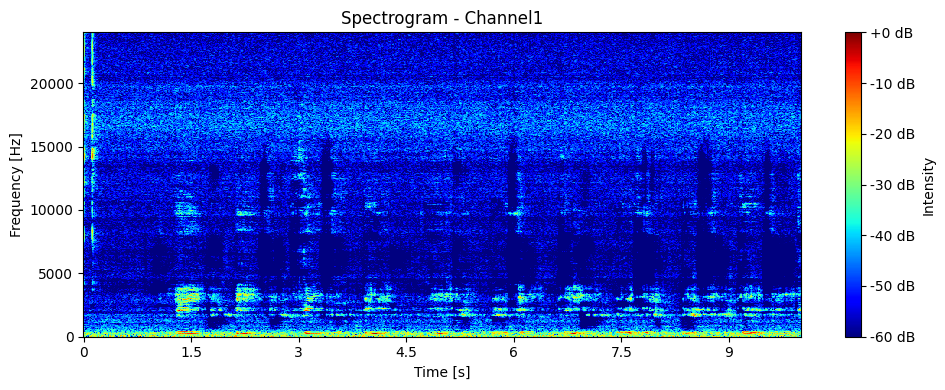

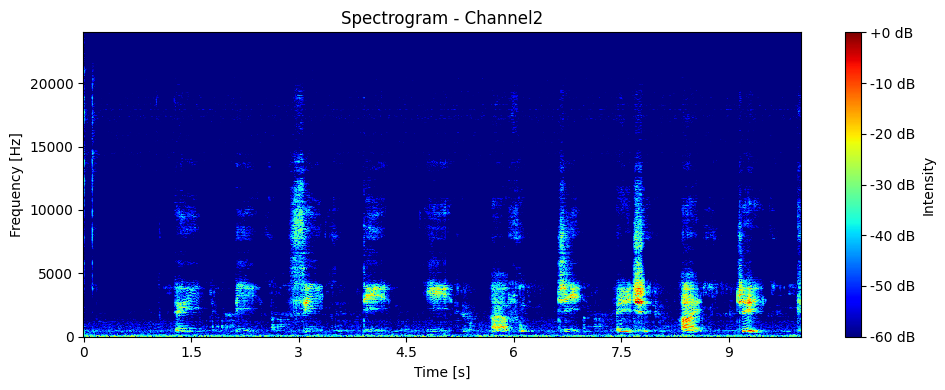

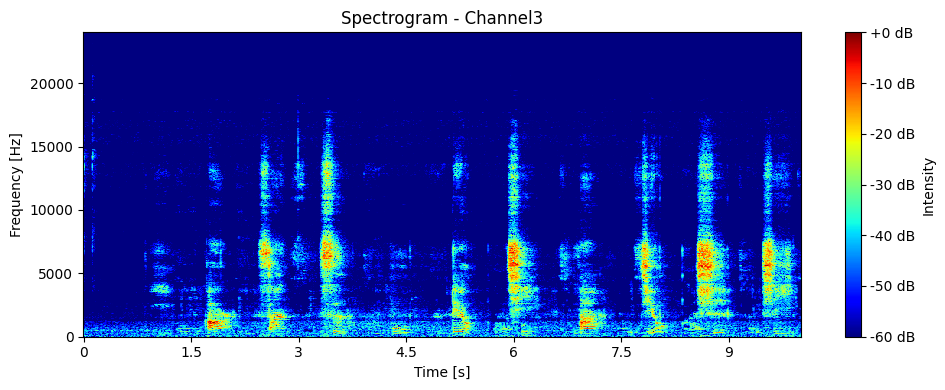

In [16]:

# audio_file_path = 'R:/code/SoundSourceSeparation/src/separation/00_02_normal.wav' 
audio_file_path = 'R:\code\SoundSourceSeparation\FastMNMF2_IP-sep-M=4-S=3-F=513-K=64-init=twostep_50it-g=5e-10-bit=64-intv_norm=10-ID=00_02_normal.wav'

# 调用函数进行绘制
plot_spectrogram_for_each_channel(audio_file_path)